Making a trial demo file

1. Explain the tools usage for astronomy in brief

2. Explain what is a GP and what is fitting a GP \
Make a sample GP (with errors, error bars, add later) and fit it

3. Explain Bayesian Analysis and what is fitting a GP \
Fit a Red Noise Kernel gp using a just the dictionary for prior

4. Using own priors, likelihoods with proper explaination \
Fit a QPO + skew gaussian prior, making own and using a conditional prior

5. Explain what an evidence is and compare the two models

6. Use plotting features for extra understanding

Plot these, with your other plots:- \
result = QPOEstimation.result.GPResult.from_json(outdir=f"{outdir}/results", label=label) \
result.plot_lightcurve()            : Plots the lightcurve and the maximum likelihood fit. \
result.plot_kernel()                : Plots the maximum likelihood kernel function. \
result.plot_max_likelihood_psd()    : ? plots max like power spectral density (periodogram) \
result.plot_residual()              : Plots the lightcurve - the max likelihood mean model and the max likelihood prediction.\
result.plot_frequency_posterior()   : Plots the frequency posterior. \
result.plot_period_posterior()      : Plots the period posterior \
result.plot_duration_posterior()    : Plots the duration posterior for the `celerite_windowed` likelihood class. \
result.plot_                        : 

mode of posteriors

get_posterior_mode_kernel(): can make similarly mean \
get_posterior_mode_gp_samples(): 

get_posteriors_of samples, corner plots2

Make sure in all functions, users can input their own kernels, means, priors_funcs, likelihood_funcs, 


Understand Hubeners plot, look for something unique \
Understand jaxns result, summary ,the two plot, getting mode of samples (max posterior) \
Make a GPResult class focussed only on the sampling part. 

----------------------
MAP and ML are maximum a posteriori, and max likelihood, can use them (same though)

The histogram we are making is a bit diff from the histogram in cornerplot, they are doing something extra , We take the weighted samples for making the histogram. (Can form two different functions) (no idea about the loop tho = loop is there so that if more than 1 params like t0_1, t0_2)

Corner plot: \ The corner plot is actually a 2d histogram!!!
The top: is 50,5,95 percentile of sample_resampled (weighted), then mean and its stdev, then map and ml \
Lines: Green: MAL_point          Red: sample mean, + std, -std

Summary:- \
{}: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est. \
_samples = result.samples[name].reshape((samples[name].shape[0], -1)) \
We do the perctiles, mean etc of normal samples, the MAP and MP is the same. (We got both hehehe)

Making this for t0 with multi params will be tough

Plan:
Make new GPResult class which takes only the sampling, caclulates MAP, ML, and makes plots, corner plots

7. Make another notebook with windowed likelihood

8. Make another notebook with data taken from hubener's repo actual lightcurves


## Gaussian Processes in Astronomy

Explain Bayesian Analysis, Gaussian Processes, Evidence, use of GPs in Astronomy 


## Sample Lightcurve

Make a sample lightcurve, and fit a Red Noise Kernel gp using a just the dictionary for prior

In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

# May shift the ahead
import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


INFO[2023-07-10 15:53:13,971]: Remote TPU is not linked into jax; skipping remote TPU.
INFO[2023-07-10 15:53:13,971]: Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO[2023-07-10 15:53:13,971]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-10 15:53:13,972]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-10 15:53:13,972]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-07-10 15:53:13,972]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


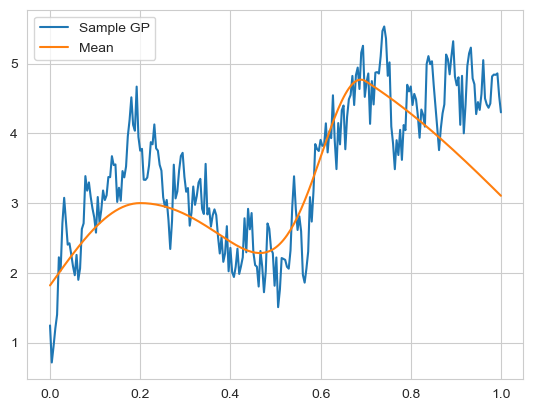

In [2]:
from gpmodelling import get_kernel, get_mean

Times = np.linspace(0,1,256)

kernel_params  = {"arn" : jnp.exp(-0.5),    "crn" : jnp.exp(1.5),
                  "aqpo": jnp.exp(-2),    "cqpo": jnp.exp(1.2),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }
mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

gp = GaussianProcess(kernel = kernel, X = Times, mean_value = mean(Times), diag = 5e-2)
# gp = GaussianProcess(kernel = kernel, X = Times, mean = mean, diag = 5e-2)

# Plotting the GP
fig, ax = plt.subplots()
ax.plot(Times, gp.sample(key = jax.random.PRNGKey(3), shape= (1,)).T, label = "Sample GP")
ax.plot(Times, mean(Times), label = "Mean"); ax.legend()

plt.show()

INFO[2023-07-10 15:53:20,633]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 15:53:20,633]: Checking if light curve is sorted.


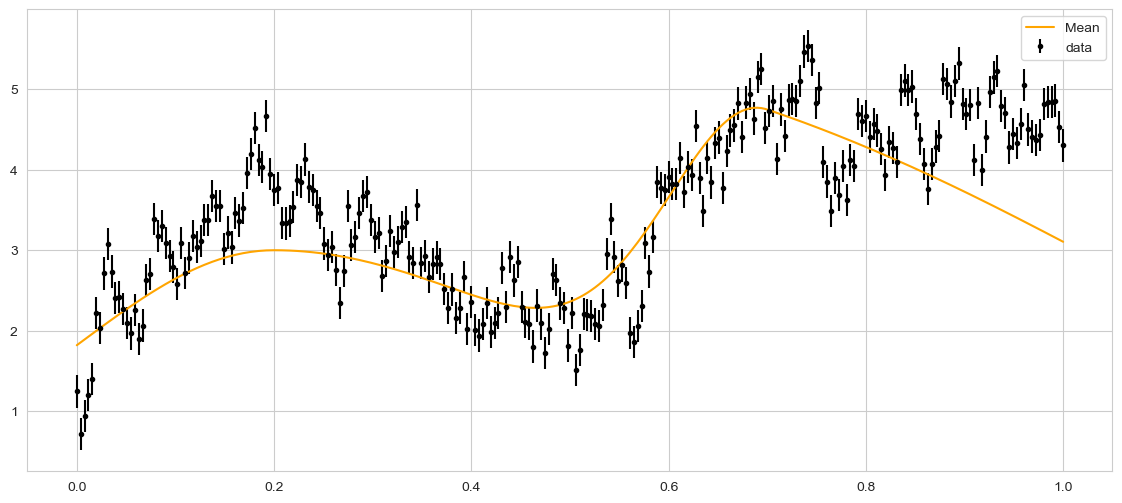

In [3]:
counts = sample = gp.sample(key = jax.random.PRNGKey(3))
yerr = (0.2)*np.ones_like(Times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
plt.errorbar(Times, sample.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(Times, mean(Times), color = "orange" ,label = "Mean"); ax.legend()

lc = Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0])

In [68]:
from jaxns import ExactNestedSampler, Model, TerminationCondition
from jaxns.utils import resample
from jax import random

class GPResult:
    def __init__(self, Lc: Lightcurve) -> None:
        self.lc = Lc
        self.time = Lc.time
        self.counts = Lc.counts
        self.Result = None

    def sample(self, prior_model=None, likelihood_model=None, **kwargs):

        self.prior_model = prior_model
        self.likelihood_model = likelihood_model

        NSmodel = Model(prior_model=self.prior_model, log_likelihood=self.likelihood_model)
        NSmodel.sanity_check(random.PRNGKey(10), S=100)

        self.Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
        Termination_reason, State = self.Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
        )
        self.Results = self.Exact_ns.to_results(State, Termination_reason)
        print("Simulation Complete")

    def print_summary(self):
        """
        Prints a summary table for the model parameters
        """
        self.Exact_ns.summary(self.Results)

    def plot_diagnostics(self):
        """
        Plots the diagnostic plots for the sampling process
        """
        self.Exact_ns.plot_diagnostics(self.Results)

    def plot_cornerplot(self):
        """
        Plots the corner plot for the sampled hyperparameters
        """
        self.Exact_ns.plot_cornerplot(self.Results)

    def get_parameters_names(self):
        """
        Returns the names of the parameters
        """
        return sorted(self.Results.samples.keys())

    def get_max_posterior_parameters(self):
        """
        Returns the optimal parameters for the model based on the NUTS sampling
        """
        max_post_idx = jnp.argmax(self.Results.log_posterior_density)
        map_points = jax.tree_map(lambda x: x[max_post_idx], self.Results.samples)
        
        return map_points

    def get_max_likelihood_parameters(self):
        """
        Retruns the maximum likelihood parameters
        """
        max_like_idx = jnp.argmax(self.Results.log_L_samples)
        max_like_points = jax.tree_map(lambda x: x[max_like_idx], self.Results.samples)

        return max_like_points
    
    def posterior_plot(self, name : str, n = 0):
        """
        Plots the posterior histogram for the given parameter
        """
        nsamples = self.Results.total_num_samples
        samples = self.Results.samples[name].reshape((nsamples, -1))[:, n]
        plt.hist(samples, bins = "auto", density = True, alpha = 1.0, label = name, fc='None', edgecolor='black')
        mean1 = jnp.mean(self.Results.samples[name])
        std1 = jnp.std(self.Results.samples[name])
        plt.axvline(mean1, color = "red", linestyle='dashed', label = "mean")
        plt.axvline(mean1 + std1, color = "green", linestyle='dotted')
        plt.axvline(mean1 - std1, linestyle='dotted', color = "green")
        plt.legend()
        plt.plot()

        pass

    def weighted_posterior_plot(self, name : str, n = 0 , rkey = random.PRNGKey(1234)):
        """
        Returns the weighted posterior histogram for the given parameter
        """
        nsamples = self.Results.total_num_samples
        log_p = self.Results.log_dp_mean
        samples = self.Results.samples[name].reshape((nsamples, -1))[:, n]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        samples_resampled = resample(rkey, samples, log_weights, S=max(10, int(self.Results.ESS)), replace=True)

        nbins = max(10, int(jnp.sqrt(self.Results.ESS)) + 1)
        binsx = jnp.linspace(*jnp.percentile(samples_resampled, jnp.asarray([0, 100])), 2 * nbins)

        plt.hist(np.asarray(samples_resampled), bins = binsx, density = True, alpha = 1.0, label = name, fc='None', edgecolor='black')
        sample_mean = jnp.average(samples, weights=weights)
        sample_std = jnp.sqrt(jnp.average((samples - sample_mean) ** 2, weights=weights))
        plt.axvline(sample_mean, color = "red", linestyle='dashed', label = "mean")
        plt.axvline(sample_mean + sample_std, color = "green", linestyle='dotted')
        plt.axvline(sample_mean - sample_std, linestyle='dotted', color = "green")
        plt.legend()
        plt.plot()

    def corner_plot(self, param1 : str, param2 : str, n1 = 0, n2 = 0, rkey = random.PRNGKey(1234)):
        """
        Plots the corner plot for the given parameters
        """
        nsamples = self.Results.total_num_samples
        log_p = self.Results.log_dp_mean
        samples1 = self.Results.samples[param1].reshape((nsamples, -1))[:, n1]
        samples2 = self.Results.samples[param2].reshape((nsamples, -1))[:, n2]

        log_weights = jnp.where(jnp.isfinite(samples2), log_p, -jnp.inf)
        nbins = max(10, int(jnp.sqrt(self.Results.ESS)) + 1)

        samples_resampled = resample(rkey, jnp.stack([samples1, samples2], axis=-1), log_weights,
                                S=max(10, int(self.Results.ESS)), replace=True)
        plt.hist2d(samples_resampled[:, 1], samples_resampled[:, 0], bins=(nbins, nbins), density=True, cmap ="GnBu")
        plt.plot()

        pass


In [23]:
# Fitting a Gp to the curve
from gpmodelling import get_prior, get_likelihood, get_gp_params

params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print(params_list)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0(the problem)
prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}
prior_model = get_prior(params_list, prior_dict)
for a in prior_model():
    print(a)

likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts, yerr = yerr)


['arn', 'crn', 'A', 't0', 'sig']
arn	() -> () <class 'numpy.float64'>
crn	() -> () <class 'numpy.float64'>
A	() -> () <class 'numpy.float64'>
t0	() -> () <class 'numpy.float64'>
sig	() -> () <class 'numpy.float64'>


In [24]:
Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-07-10 16:00:51,909]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 16:00:51,911]: Checking if light curve is sorted.
INFO[2023-07-10 16:00:52,160]: Sanity check...
INFO[2023-07-10 16:00:52,163]: Sanity check passed


Simulation Complete


In [90]:
results = Gpresult.Results
print(results.log_Z_mean)

-105.1646012290386


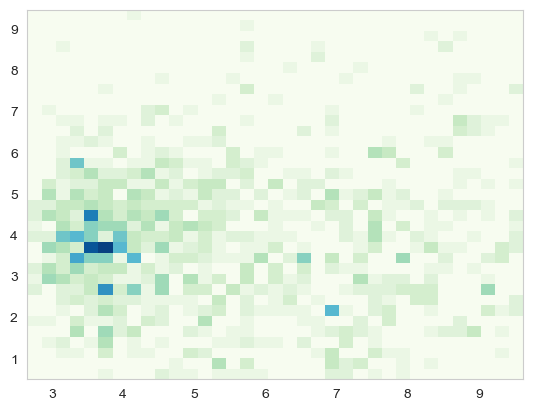

In [26]:
results = Gpresult.Results
Exactns = Gpresult.Exact_ns

Gpresult.corner_plot("A", "arn", n1 = 0, n2 = 0)

In [76]:
# MAP dictionary
max_map_idx = jnp.argmax(results.log_posterior_density) # These are sorted, so the last id is max
map_points = jax.tree_map(lambda x: x[max_map_idx], results.samples)
print(max_map_idx)
print("map_points: ",map_points)

# MAL dictionary
max_like_idx = jnp.argmax(results.log_L_samples)
print(max_like_idx)
max_like_points = jax.tree_map(lambda x: x[max_like_idx], results.samples)
print("ml_points: ",max_like_points)

# Normal histogram # Special Histogram # Corner Plot

4651
map_points:  {'A': Array(4.33481684, dtype=float64), 'arn': Array(3.03475781, dtype=float64), 'crn': Array(5.50507101, dtype=float64), 'sig': Array(0.63535535, dtype=float64), 't0': Array(0.93475147, dtype=float64)}
4651
ml_points:  {'A': Array(4.33481684, dtype=float64), 'arn': Array(3.03475781, dtype=float64), 'crn': Array(5.50507101, dtype=float64), 'sig': Array(0.63535535, dtype=float64), 't0': Array(0.93475147, dtype=float64)}


[]

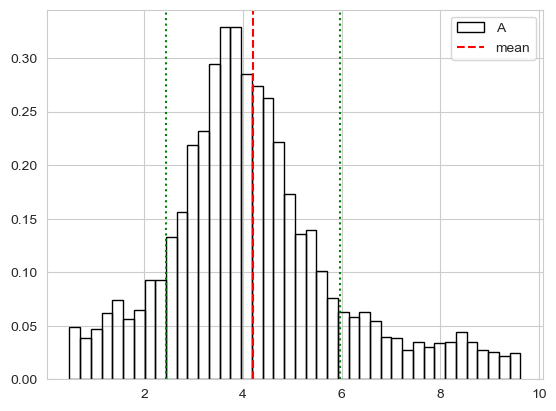

In [119]:
# Normal histogram:
plt.hist(results.samples['A'], bins = "auto", density = True, alpha = 1.0, label = "A", fc='None', edgecolor='black')
mean1 = jnp.mean(results.samples['A'])
std1 = jnp.std(results.samples['A'])
plt.axvline(mean1, color = "red", linestyle='dashed', label = "mean")
plt.axvline(mean1 + std1, color = "green", linestyle='dotted')
plt.axvline(mean1 - std1, linestyle='dotted', color = "green")
plt.legend()
plt.plot()

In [27]:
from jaxns.special_priors import ForcedIdentifiability

params_list2 = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print(params_list2)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0(the problem)
n = 2
prior_dict2 = {
    "A": tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)),
    # "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[0] + 0.1*T),
    "t0" : ForcedIdentifiability(n = n, low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T, name='t0'),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n)),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}
prior_model2 = get_prior(params_list2, prior_dict2)
for a in prior_model2():
    print(a)

likelihood_model2 = get_likelihood(params_list2, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts)

['arn', 'crn', 'A', 't0', 'sig']
arn	() -> () <class 'numpy.float64'>
crn	() -> () <class 'numpy.float64'>
A	(2,) -> (2,) <class 'numpy.float64'>
t0	(2,) -> (2,) float64
sig	(2,) -> (2,) <class 'numpy.float64'>


In [28]:
Gpresult2 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult2.sample(prior_model = prior_model2, likelihood_model = likelihood_model2)

INFO[2023-07-10 16:02:00,923]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 16:02:00,924]: Checking if light curve is sorted.
INFO[2023-07-10 16:02:01,281]: Sanity check...
INFO[2023-07-10 16:02:01,431]: Sanity check passed


Simulation Complete


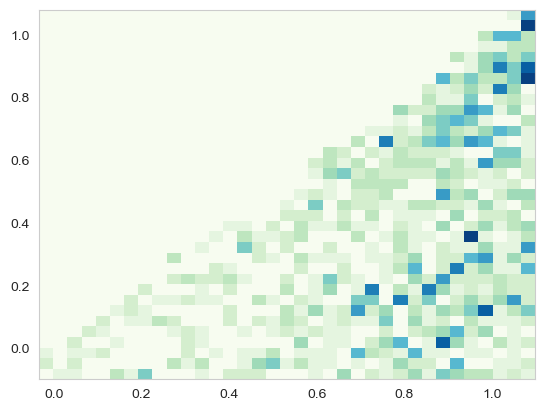

In [48]:
results2 = Gpresult2.Results
Exactns2 = Gpresult.Exact_ns

# Gpresult2.corner_plot("A", "arn", n1 = 0, n2 = 0)
# Gpresult2.weighted_posterior_plot("A", n = 1)
Gpresult2.corner_plot("t0", "t0", n1 = 0, n2 = 1)

vars  ['A', 'arn', 'crn', 'sig', 't0']
ndims  5
nsamples  4652
max_like_idx  4651
map_idx  4651
log_p  [-2.09081245e+04 -1.27664460e+04 -6.96450433e+03 ... -9.51174679e+00
 -9.49830973e+00 -9.47985661e+00]
nbins  35
n1  1
ESS  1197
samples1_resampled  (1197,)
samples1_resampled  [1.85376748 2.98803686 3.74758828 ... 1.6511561  3.62486209 4.34942907]
binsx  (70,)


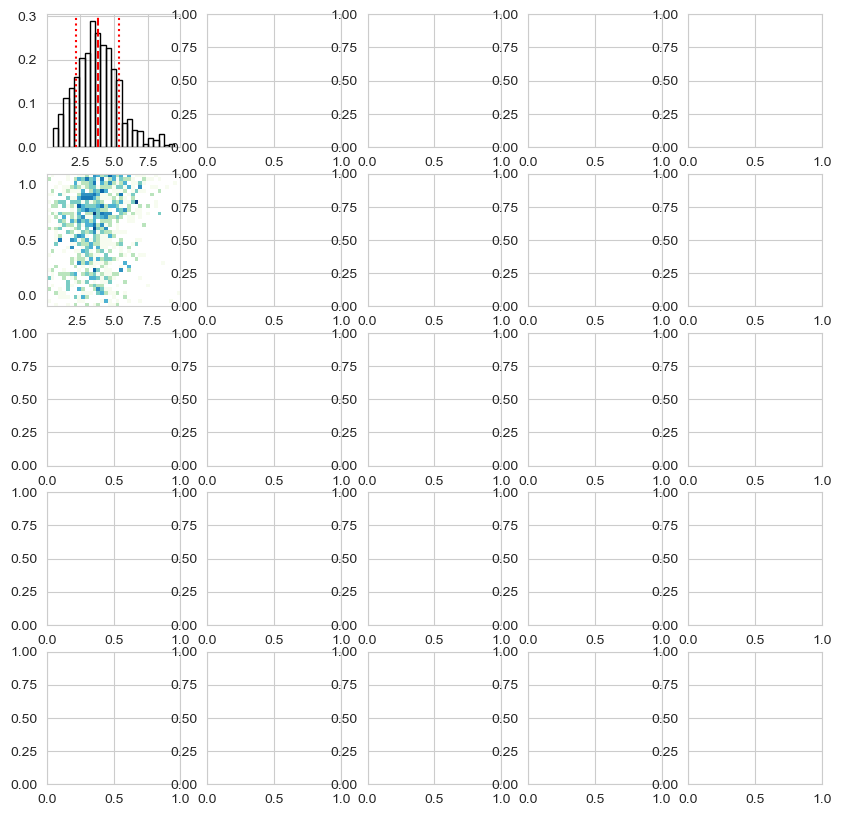

In [124]:
# Will do all of this in double
from jaxns.utils import resample
from jaxns.plotting import _get_vars, _get_ndims
from jaxns.internals.shapes import tuple_prod
from matplotlib import colors

vars = None
rkey0 = random.PRNGKey(123496)
vars = _get_vars(results, vars)  # gets variable names
print("vars ",vars)

ndims = _get_ndims(results, vars)
print("ndims ",ndims)                    # number of params

figsize = min(20, max(4, int(2 * ndims)))    # 20, (4,10)
fig, axs = plt.subplots(ndims, ndims, figsize=(figsize, figsize))

nsamples = results.total_num_samples
print("nsamples ",nsamples)

max_like_idx = jnp.argmax(results.log_L_samples)
print("max_like_idx ",max_like_idx)
map_idx = jnp.argmax(results.log_posterior_density)
print("map_idx ",map_idx)

log_p = results.log_dp_mean
print("log_p ",log_p)
nbins = max(10, int(jnp.sqrt(results.ESS)) + 1)
print("nbins ",nbins) # so, in this case on ly 35 bins 
lims = {}
dim = 0

key = "A"
key2 = "t0"
n1 = tuple_prod(results.samples[key].shape[1:])
print("n1 ",n1)
print("ESS ",int(results.ESS))
for i in range(n1):
    samples1 = results.samples[key].reshape((nsamples, -1))[:, i]
    weights = jnp.where(jnp.isfinite(samples1), jnp.exp(log_p), 0.)
    log_weights = jnp.where(jnp.isfinite(samples1), log_p, -jnp.inf)
    samples1 = jnp.where(jnp.isfinite(samples1), samples1, 0.)
    rkey0, rkey = random.split(rkey0, 2)
    samples1_resampled = resample(rkey, samples1, log_weights, S=max(10, int(results.ESS)), replace=True)
    print("samples1_resampled ",samples1_resampled.shape) # return ESS samples
    print("samples1_resampled ",samples1_resampled)
    binsx = jnp.linspace(*jnp.percentile(samples1_resampled, jnp.asarray([0, 100])), 2 * nbins)
    print("binsx ",binsx.shape) # 70 bins from 0 to 100 perctile of samples1_resampled
    ax = axs[0][0]
    ax.hist(np.asarray(samples1_resampled), bins='auto', fc='None', edgecolor='black', density=True)
    sample_mean = jnp.average(samples1, weights=weights)
    sample_std = jnp.sqrt(jnp.average((samples1 - sample_mean) ** 2, weights=weights))
    ax.axvline(sample_mean, linestyle='dashed', color='red')
    ax.axvline(sample_mean + sample_std, linestyle='dotted', color='red')
    ax.axvline(sample_mean - sample_std, linestyle='dotted', color='red')

    ax = axs[1][0]
    samples2 = results.samples[key2].reshape((nsamples, -1))[:, i]
    weights = jnp.where(jnp.isfinite(samples2), jnp.exp(log_p), 0.)
    log_weights = jnp.where(jnp.isfinite(samples2), log_p, -jnp.inf)
    samples2 = jnp.where(jnp.isfinite(samples2), samples2, 0.)
    rkey0, rkey = random.split(rkey0, 2)
    samples2_resampled = resample(rkey, jnp.stack([samples2, samples1], axis=-1), log_weights,
                                S=max(10, int(results.ESS)), replace=True)
    ax.hist2d(samples2_resampled[:, 1], samples2_resampled[:, 0], bins=(nbins, nbins), density=True, norm = colors.LogNorm(),
          cmap ="GnBu")


In [90]:
print(results.samples["A"].shape)
print(results2.samples["A"].shape)
# These have everything, so i can just as t0, and also 1,2 for t01 and t02 and do the calculations

(4652,)
(5652, 2)


vars2  ['A', 'arn', 'crn', 'sig', 't0']
ndims2  8
nsamples2  5652
max_like_idx2  5651
map_idx2  5651
log_p2  [-2.56422943e+05 -4.01318904e+04 -1.53354260e+04 ... -1.05794076e+01
 -1.05046018e+01 -1.04106419e+01]
nbins2  35
n1  2
(5652, 2)
(5652,)
(5652, 2)
(5652,)


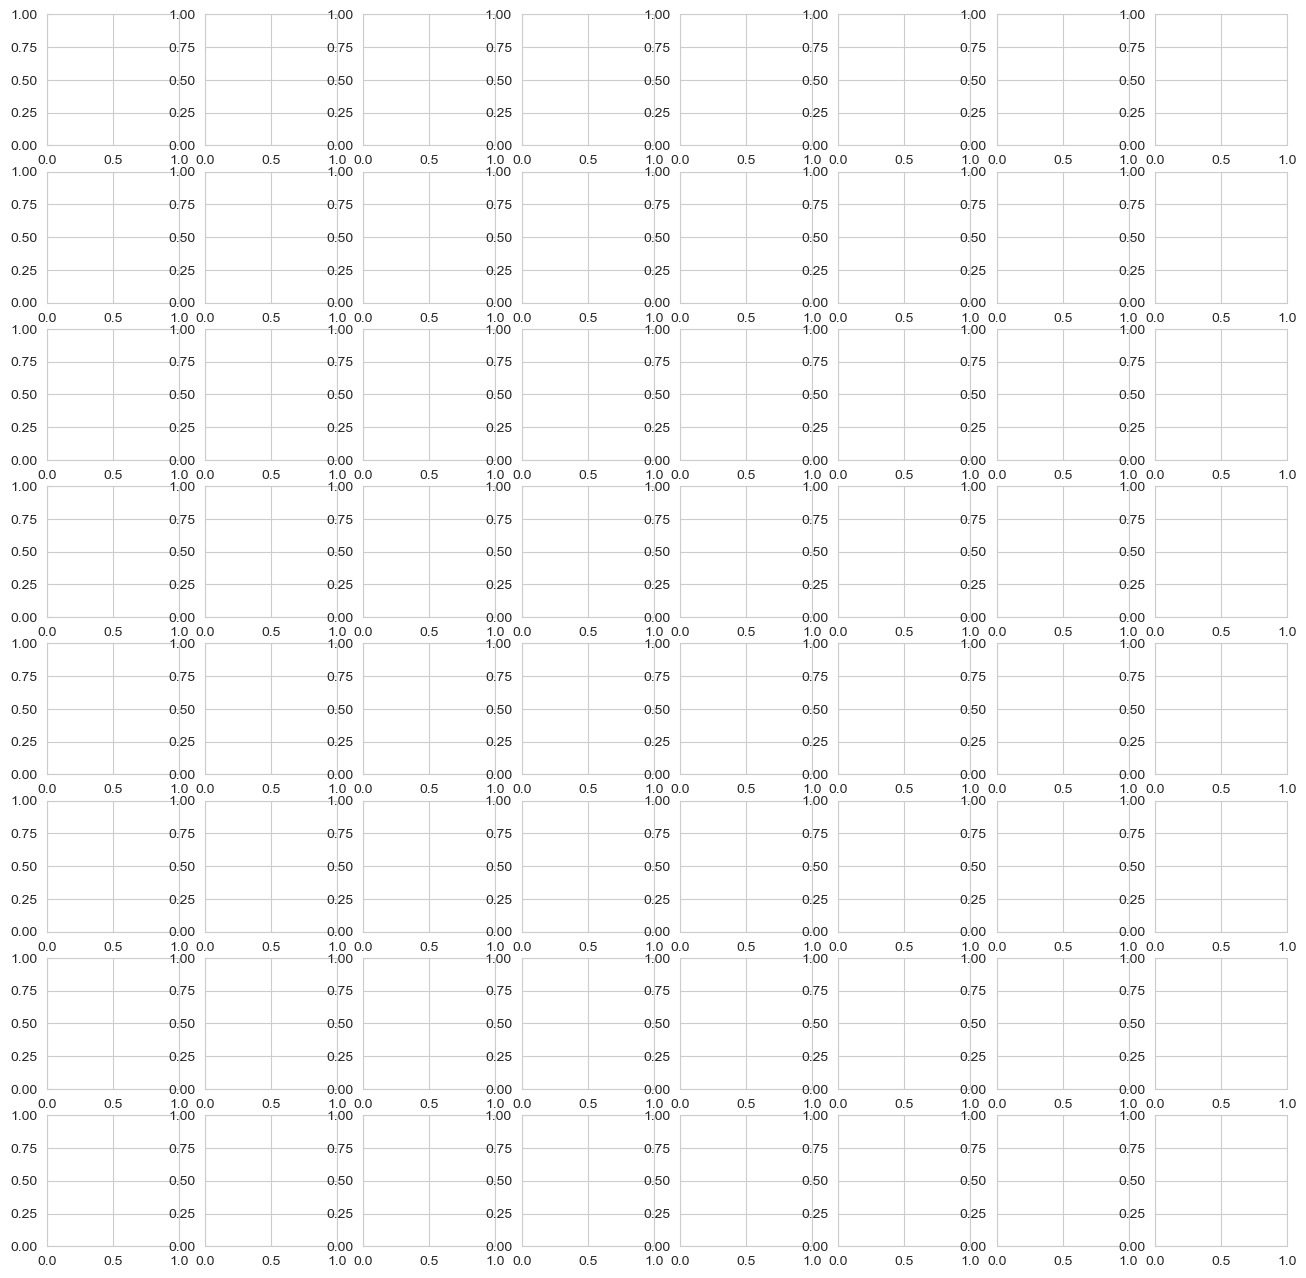

In [104]:
# Double

vars = None
rkey0 = random.PRNGKey(123496)
vars2 = _get_vars(results2, vars)  # gets variable names
print("vars2 ",vars2)

ndims2 = _get_ndims(results2, vars2)
print("ndims2 ",ndims2)                    # number of params (8 now)

figsize2 = min(20, max(4, int(2 * ndims2)))    # 20, (4,10)
fig, axs = plt.subplots(ndims2, ndims2, figsize=(figsize2, figsize2))

nsamples2 = results2.total_num_samples
print("nsamples2 ",nsamples2)

max_like_idx2 = jnp.argmax(results2.log_L_samples)
print("max_like_idx2 ",max_like_idx2)
map_idx2 = jnp.argmax(results2.log_posterior_density)
print("map_idx2 ",map_idx2)

log_p2 = results2.log_dp_mean
print("log_p2 ",log_p2)
nbins2 = max(10, int(jnp.sqrt(results2.ESS)) + 1)
print("nbins2 ",nbins2) # so, in this case on ly 35 bins 
lims2 = {}
dim2 = 0

key2 = "A"
n1 = tuple_prod(results2.samples[key2].shape[1:])
print("n1 ",n1)
for i in range(n1):
    # print(results2.samples[key].shape)
    # --------------------------------------------------- gives the ith array of samples
    samples1 = results2.samples[key].reshape((nsamples2, -1))[:, i] # makes it (5652,) ()
    # print(samples1.shape)
    weights = jnp.where(jnp.isfinite(samples1), jnp.exp(log_p), 0.)
    log_weights = jnp.where(jnp.isfinite(samples1), log_p, -jnp.inf)
    samples1 = jnp.where(jnp.isfinite(samples1), samples1, 0.)
    rkey0, rkey = random.split(rkey0, 2)
    samples1_resampled = resample(rkey, samples1, log_weights, S=max(10, int(results.ESS)), replace=True)
    print("samples1_resampled ",samples1_resampled.shape) # return ESS samples
    print("samples1_resampled ",samples1_resampled)
    binsx = jnp.linspace(*jnp.percentile(samples1_resampled, jnp.asarray([0, 100])), 2 * nbins)
    print("binsx ",binsx.shape) # 70 bins from 0 to 100 perctile of samples1_resampled
    ax = axs[0][0]
    ax.hist(np.asarray(samples1_resampled), bins='auto', fc='None', edgecolor='black', density=True)
    sample_mean = jnp.average(samples1, weights=weights)
    sample_std = jnp.sqrt(jnp.average((samples1 - sample_mean) ** 2, weights=weights))
    ax.axvline(sample_mean, linestyle='dashed', color='red')
    ax.axvline(sample_mean + sample_std, linestyle='dotted', color='red')
    ax.axvline(sample_mean - sample_std, linestyle='dotted', color='red')
    



Double means, log uniform priors, own priors, windowed priors, make lightcurve 



4. Using own priors, likelihoods with proper explaination \
Fit a QPO + skew gaussian prior, making own and using a conditional prior

In [83]:
# QPO prior
from jaxns import Prior
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0 with n = 2

def prior_model3():
    arn = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='arn')
    crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)), name='crn')
    aqpo = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='aqpo')
    cqpo = yield Prior(tfpd.Uniform(low = 1/10/T, high = jnp.log(f)), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/2 ), name='freq')

    n = 2
    A = yield Prior(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)), name='A')
    
    # t0 = []
    # scale_bij = tfp.bijectors.Scale(scale = Times[-1] - Times[0])
    # shift_bij = tfp.bijectors.Shift(shift= Times[0])
    # for i in range(n):
    #     underlying_beta = tfpd.Beta(
    #         concentration1=jnp.asarray(1., float_type),
    #         concentration0=jnp.asarray(n - i, float_type)
    #     )
    #     t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
    #     # Updating the shift and scale here
    #     scale_bij = tfp.bijectors.Scale(scale= Times[-1] - t)
    #     shift_bij = tfp.bijectors.Shift(shift=t)
    #     t0.append(t)
    # t0 = jnp.stack(t0)
    t0 = yield ForcedIdentifiability(n = n, low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T, name='t0')
    sig = yield Prior(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n)), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig


likelihood_model3 = get_likelihood(params_list3, kernel_type= "QPO_plus_RN", mean_type = "gaussian", Times = Times, counts = counts)


['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [84]:
Gpresult3 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-07-10 19:20:19,222]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-10 19:20:19,227]: Checking if light curve is sorted.
INFO[2023-07-10 19:20:20,026]: Sanity check...
INFO[2023-07-10 19:20:20,032]: Sanity check passed


Simulation Complete


In [85]:
result3 = Gpresult3.Results
sorted(result3.samples.keys())

['A', 'aqpo', 'arn', 'cqpo', 'crn', 'freq', 'sig', 't0']

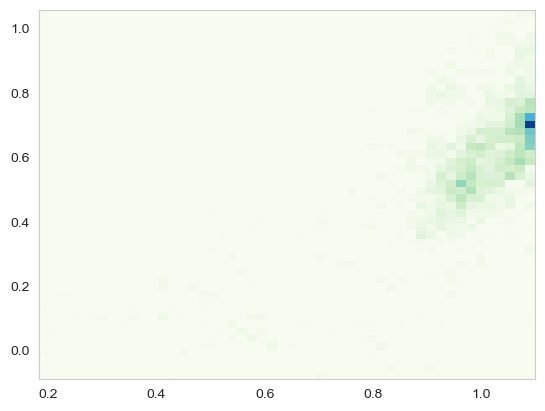

In [87]:
# Gpresult3.corner_plot("A", "arn", n1 = 0, n2 = 0)
# Gpresult3.weighted_posterior_plot("A", n = 1)
# Gpresult3.posterior_plot("A", n = 1)
Gpresult3.corner_plot("t0", "t0", n1 = 0, n2 = 1)

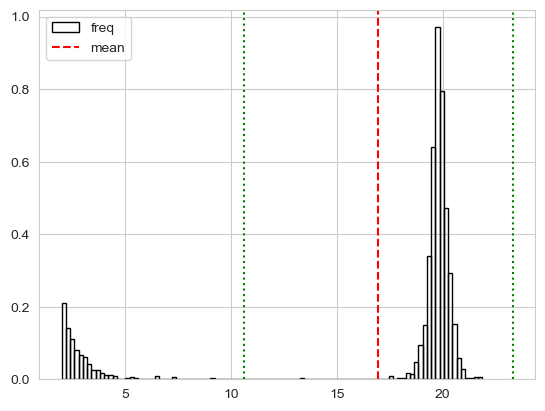

In [88]:
Gpresult3.weighted_posterior_plot("freq")

--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 777040
# samples: 10000
# slices: 283832.0
# slices / acceptance: 34.0
# likelihood evals / sample: 77.7
# likelihood evals / slice: 2.7
--------
logZ=-112.57 +- 0.15
H=110.0
ESS=2496
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 1.52 +- 0.81 | 0.71 / 1.39 / 2.41 | 0.92 | 0.92
A[1]: 1.9 +- 1.1 | 1.0 / 1.7 / 3.1 | 3.0 | 3.0
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.03 +- 0.85 | 0.53 / 0.79 / 1.69 | 0.52 | 0.52
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 5.1 +- 1.2 | 3.5 / 5.5 / 6.4 | 3.5 | 3.5
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 0.6 +- 1.1 | 0.1 / 0.2 / 1.0 | 0.1 | 0.1
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.11 +- 0.71 | 2.34 / 2.92 / 4.12 | 4.

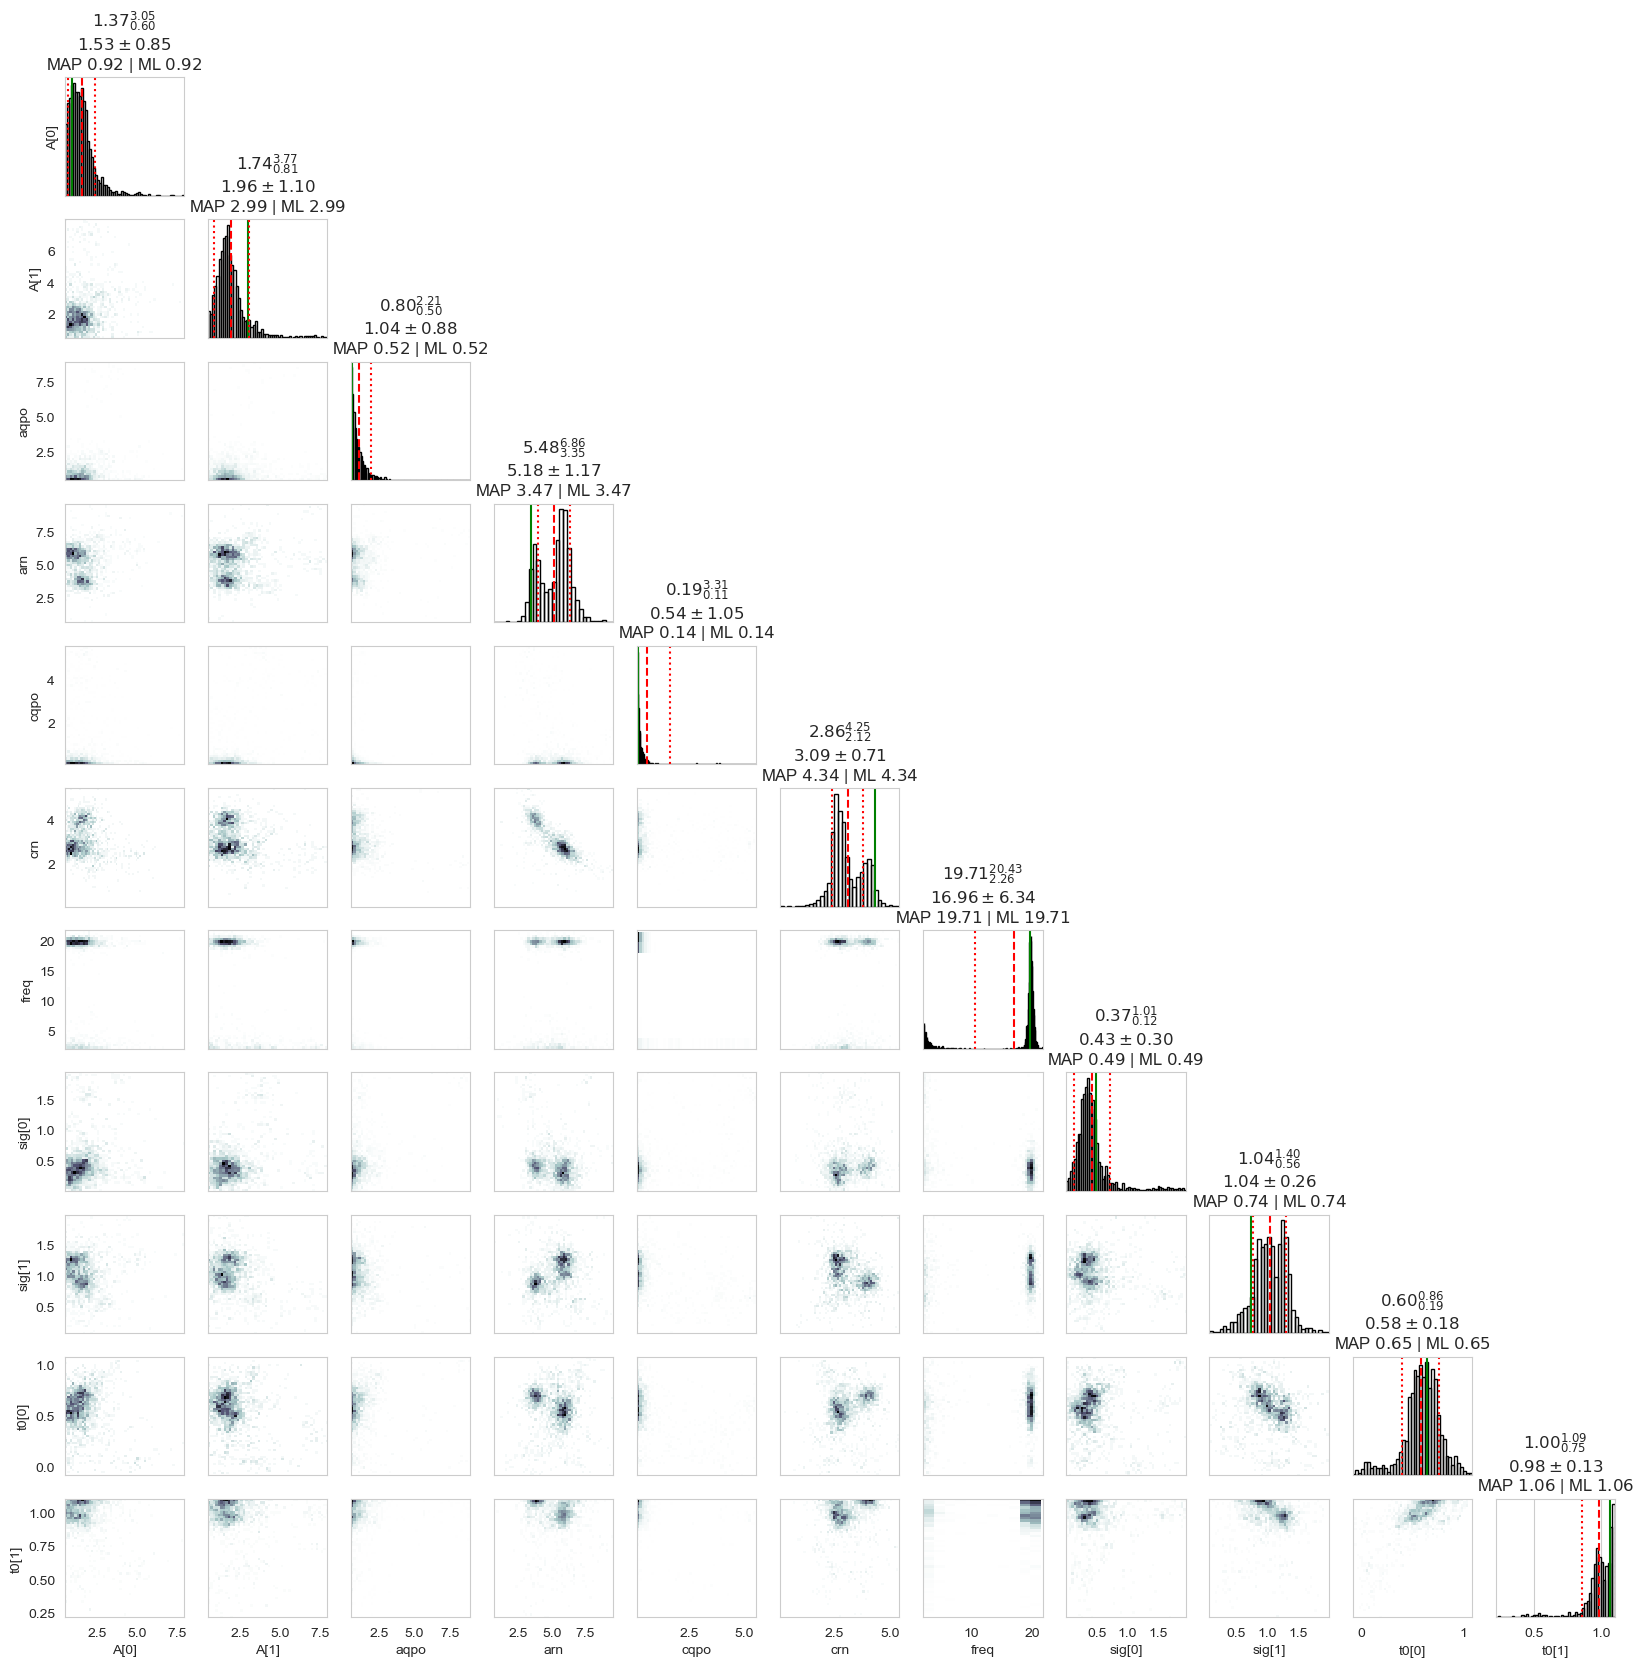

In [89]:
Gpresult3.print_summary()
Gpresult3.plot_cornerplot()